# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 06b (Additional Reading): Tricks of The Trade for TF 1.x</span><span style="color:red;  font-size: 18px">** (reference)</span> #

**The purpose of this tutorial is to demonstrate the tricks of the trade in deep learning. The following topics are presented:**
1. How to apply weight initialization, gradient clipping, batch normalization, and dropout to regularize deep networks and stabilize a training process.
2. How to reuse a pre-trained model and further do fine-tuning.
3. How to reuse a part of a pre-trained model to build up a new model.

***Acknowledgement***: *this tutorial was developed based on the Chapter 11 materials from the book `Hands-on Machine Learning with Scikit-learn and Tensorflow`.*

---

## <span style="color:#0b486b">I. Preparation</span> ##

As usual, we do some preparation in advance by importing necessary libraries and modules as well as doing some setup. 

In [15]:
# To support both python 2 and python 3
# Common imports
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## <span style="color:#0b486b">II. Weight Initializier, User-defined Activation, and Batch Normalization</span> ##

### <span style="color:#0b486b">II.1. Non-saturating Leaky ReLU activation function</span> ###

We use the `Leaky ReLU` activation function, which is defined as $leaky\_relu(z)=\max\{\alpha z, z\}$ where $\alpha$ is a parameter. Unlike `sigmoid`, and `tanh`, `Leaky ReLU` is non-saturating. We now declare this function and visualize this activation function.

In [16]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


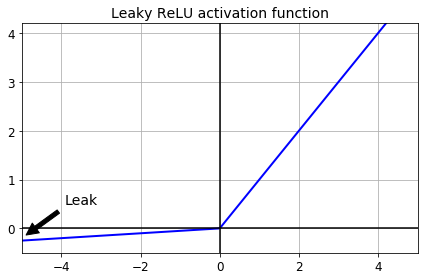

In [17]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

### <span style="color:#0b486b">II.2. Data processing</span> ###

We use `tf.keras.datasets.mnist` to load the `MNIST` dataset since `tf.examples.tutorials.mnist` is deprecated. 

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

Here is the code to randomly generate mini-batches. We first permuate the training set $X, y$ and split them into mini-batches. Note that the keyword `yield` helps us create a generator of mini-batches.
- Generators are iterators, but you can only iterate over them once. It’s because they do not store all the values in memory, they generate the values on the fly.

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

### <span style="color:#0b486b">II.3. Xavier and He initialization</span> ### 

In training a deep learning model, the `initialization of weight matrices` is quite important. We need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate.

There are two well-known initialization strategies, namely `Xavier` and `He` initializers. The following tables summarize the technical details of these two initializers. <br/><br/>

<img src="./images/initializers.png" align="center" width=600/>

It is very convenient to apply `Xavier` and `He` initializers in `TensorFlow`
- **He initializer**: `he_init = tf.contrib.layers.variance_scaling_initializer()` and  `hidden1 = fully_connected(X, n_hidden1, weights_initializer=he_init, scope="h1")`
- **Xavier initializer**: `xavier_init = tf.contrib.layers.xavier_initializer()` and  `hidden1 = fully_connected(X, n_hidden1, weights_initializer=xavier_init, scope="h1")`

### <span style="color:#0b486b">II.4. Batch normalization</span>

First introduced by Ioffe and Szgedy in their 2015 paper, *Batch Normalization: Accelerating Deep
Network Training by Reducing Internal Covariate Shift*, batch normalization layers (or BN for
short), as the name suggests, are used to normalize the activations of a given input volume before
passing it into the next layer in the network.

The technique consists of adding an operation in the model just after the activation
function of each layer, simply zero-centering and normalizing the inputs, then scaling
and shifting the result using two new parameters per layer (one for scaling, the other
for shifting). In other words, this operation lets the model learn the optimal scale and
mean of the inputs for each layer.
- The order of operations is `INPUT => CONV => ACT => BN`

Batch normalization has been shown to be extremely effective at reducing the number of
epochs it takes to train a neural network. Batch normalization also has the added benefit of helping
“stabilize” training, allowing for a larger variety of learning rates and regularization strengths. Using
batch normalization doesn’t alleviate the need to tune these parameters of course, but it will make
your life easier by making the learning rate and regularization less volatile and more straightforward
to tune.

**Training phase**
- Let $x$ be our mini-batch after activation. We then compute the normalized $\hat{x}$ via
the following equation:
  - $\hat{x}=\frac{x-\mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$ where $\epsilon$ is a small positive value such as $1e-7$
  - The empirical mean $\mu_B=\frac{1}{m}\sum_{i=1}^{m}x_i$ where $m$ is the batch size
  - The empirical variance $\sigma_B^{2}= \frac{1}{m}\sum_{i=1}^{m}\left(x_i-\mu_B\right)^2$
- We scale the normalized $\hat{x}$
  - $z_i=\gamma \hat{x}_i + \beta$ where $\gamma, \beta>0$ are two learning parameters
 
**Testing phase**
-  At testing time, we replace the mini-batch $\mu_B$ and $\sigma_B$ with running averages of $\tilde{\mu_B}$ and $\tilde{\sigma_B}$ computed during the training process.
   - $\tilde{\mu_B}=(1-\theta) \tilde{\mu_B} + \theta \mu_B$ and $\tilde{\sigma_B}^2=(1-\theta)\tilde{\sigma_B}^2 + \theta \sigma_B^2$ where $0< \theta <1$

### <span style="color:#0b486b">II.5. Dropout</span> ### 

Dropout is actually a form of regularization that aims to help prevent overfitting by increasing testing accuracy, perhaps at the expense of training accuracy. For each mini-batch in our training set, dropout layers, with probability $p$,
randomly disconnect inputs from the preceding layer to the next layer in the network architecture.

The following figure visualizes this concept where we randomly disconnect with probability $p = 0.5$ the
connections between two FC layers for a given mini-batch. Again, notice how half of the connections are severed for this mini-batch. After the forward and backward passes are computed for the minibatch, we re-connect the dropped connections, and then sample another set of connections to drop.

<img src="./images/dropout.png" align="center" width=600/>

### <span style="color:#0b486b">II.6. All together</span> ### 

Declare `Leaky ReLU` using `TensorFlow`

In [33]:
def leaky_relu(z, alpha= 0.01, name=None):
    return tf.maximum(alpha * z, z, name=name)

<span style="color:#0b486b">**Construction phase** </span> <br/>
\- To avoid repeating the code, we predefine `my_batch_norm_layer` and `my_dense_layer` using the `partial` function in `functools`

In [34]:
from functools import partial
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
batch_norm_momentum = 0.9
learning_rate= 0.01

In [35]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            activation= leaky_relu,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = my_batch_norm_layer(hidden1)
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = my_batch_norm_layer(hidden2)
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

In [36]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

<span style="color:#0b486b">**Execution phase** </span> <br/>
\- Since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()`, we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [37]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs=20
batch_size=32

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        accuracy_train= accuracy.eval(feed_dict={X:X_train, y:y_train})
        print(epoch+1, "Train accuracy:", accuracy_train, "\tValidation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

1 Train accuracy: 0.96125454 	Validation accuracy: 0.9576
2 Train accuracy: 0.9745273 	Validation accuracy: 0.9666
3 Train accuracy: 0.98145455 	Validation accuracy: 0.9712
4 Train accuracy: 0.98661816 	Validation accuracy: 0.9768
5 Train accuracy: 0.9891091 	Validation accuracy: 0.9758
6 Train accuracy: 0.9912 	Validation accuracy: 0.9786
7 Train accuracy: 0.99243635 	Validation accuracy: 0.9802
8 Train accuracy: 0.9944 	Validation accuracy: 0.9774
9 Train accuracy: 0.99523634 	Validation accuracy: 0.9792
10 Train accuracy: 0.99645454 	Validation accuracy: 0.9806
11 Train accuracy: 0.9969818 	Validation accuracy: 0.9812
12 Train accuracy: 0.9971273 	Validation accuracy: 0.979
13 Train accuracy: 0.9977818 	Validation accuracy: 0.981
14 Train accuracy: 0.9979454 	Validation accuracy: 0.98
15 Train accuracy: 0.9981091 	Validation accuracy: 0.9816
16 Train accuracy: 0.9985091 	Validation accuracy: 0.983
17 Train accuracy: 0.9986182 	Validation accuracy: 0.9816
18 Train accuracy: 0.9988909

**<span style="color:red">Exercise 1</span>:** Rewrite the above code to change the order of batch normalization layer as `INPUT => CONV => BN => ACT`. This is the order proposed in the original paper of batch normalization. Compare the experimental results of the two orders of batch normalization.

**<span style="color:red">Exercise 2</span>:** Rewrite the above code to apply the dropout to the `hidden1` and `hidden2` layers with the dropout rate $r=0.2$. Note that you can use the `tf.layers.dropout` as shown in [this link](https://www.tensorflow.org/api_docs/python/tf/layers/dropout). Compare to the case without using the dropout technique.

## <span style="color:#0b486b">III. Gradient Clipping</span> ##

A popular technique known as `gradient clipping` to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural networks).

<span style="color:#0b486b">**Construction phase** </span> <br/>

In [38]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

In [39]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

<span style="color:#0b486b">**Applying gradient clipping** </span> <br/>
\- We clip the gradients with respect to the variables to a predefined interval and then apply the capped gradients when updating these variables (i.e., weight matrices and biases).

In [40]:
learning_rate= 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [41]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

<span style="color:#0b486b">**Execution phase** </span> <br/>

In [42]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size = 200

In [43]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        accuracy_train= accuracy.eval(feed_dict={X:X_train, y:y_train})
        print(epoch+1, "Train accuracy:", accuracy_train, "\tValidation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

1 Train accuracy: 0.29654545 	Validation accuracy: 0.2876
2 Train accuracy: 0.78532726 	Validation accuracy: 0.7942
3 Train accuracy: 0.87398183 	Validation accuracy: 0.8794
4 Train accuracy: 0.8998 	Validation accuracy: 0.906
5 Train accuracy: 0.91007274 	Validation accuracy: 0.9162
6 Train accuracy: 0.9156182 	Validation accuracy: 0.9214
7 Train accuracy: 0.9244182 	Validation accuracy: 0.929
8 Train accuracy: 0.9322 	Validation accuracy: 0.9356
9 Train accuracy: 0.9336182 	Validation accuracy: 0.9382
10 Train accuracy: 0.939 	Validation accuracy: 0.9416
11 Train accuracy: 0.9438364 	Validation accuracy: 0.9456
12 Train accuracy: 0.9468727 	Validation accuracy: 0.947
13 Train accuracy: 0.94534546 	Validation accuracy: 0.9476
14 Train accuracy: 0.95207274 	Validation accuracy: 0.953
15 Train accuracy: 0.9558182 	Validation accuracy: 0.9564
16 Train accuracy: 0.9562 	Validation accuracy: 0.9566
17 Train accuracy: 0.9590182 	Validation accuracy: 0.9576
18 Train accuracy: 0.9605455 	Vali

## <span style="color:#0b486b">III. Reusing Pretrained Layers</span> ##

### <span style="color:#0b486b">III.1. Reusing a TensorFlow Model </span> ###

First we need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that we can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file we should load:

In [32]:
reset_graph()
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

with tf.Session() as sess: 
    file_writer = tf.summary.FileWriter(logdir='logs/my-model', session=sess) 

Next we need to get a handle on all the operations we will need for training. If we don't know the graph's structure, we can list all the operations:

In [60]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Once we know which operations you need, we can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [62]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If we are the author of the original model, we could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [63]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse our model will be able to simply write:

In [64]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now we can start a session, restore the model's state and continue training on our data:

In [66]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        accuracy_train= accuracy.eval(feed_dict={X:X_train, y:y_train})
        print(epoch+1, "Train accuracy:", accuracy_train, "\tValidation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")  

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
1 Train accuracy: 0.9667636 	Validation accuracy: 0.9632
2 Train accuracy: 0.96616364 	Validation accuracy: 0.9646
3 Train accuracy: 0.9689091 	Validation accuracy: 0.9648
4 Train accuracy: 0.9703636 	Validation accuracy: 0.9642
5 Train accuracy: 0.97041816 	Validation accuracy: 0.966
6 Train accuracy: 0.972 	Validation accuracy: 0.9672
7 Train accuracy: 0.9737818 	Validation accuracy: 0.9682
8 Train accuracy: 0.9738182 	Validation accuracy: 0.9664
9 Train accuracy: 0.9723273 	Validation accuracy: 0.966
10 Train accuracy: 0.97581816 	Validation accuracy: 0.9712
11 Train accuracy: 0.9753091 	Validation accuracy: 0.9674
12 Train accuracy: 0.9774909 	Validation accuracy: 0.9704
13 Train accuracy: 0.9790364 	Validation accuracy: 0.971
14 Train accuracy: 0.9799273 	Validation accuracy: 0.9706
15 Train accuracy: 0.9804909 	Validation accuracy: 0.9696
16 Train accuracy: 0.9794 	Validation accuracy: 0.9702
17 Train accuracy: 0.979

Alternatively, if we have access to the Python code that built the original graph, we can use it instead of `import_meta_graph()`:

In [67]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [68]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        accuracy_train= accuracy.eval(feed_dict={X:X_train, y:y_train})
        print(epoch+1, "Train accuracy:", accuracy_train, "\tValidation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
1 Train accuracy: 0.96516365 	Validation accuracy: 0.9642
2 Train accuracy: 0.96785456 	Validation accuracy: 0.9628
3 Train accuracy: 0.96681815 	Validation accuracy: 0.9654
4 Train accuracy: 0.9696364 	Validation accuracy: 0.9652
5 Train accuracy: 0.9694 	Validation accuracy: 0.9642
6 Train accuracy: 0.96721816 	Validation accuracy: 0.9648
7 Train accuracy: 0.97318184 	Validation accuracy: 0.969
8 Train accuracy: 0.9746182 	Validation accuracy: 0.9686
9 Train accuracy: 0.9746364 	Validation accuracy: 0.9684
10 Train accuracy: 0.9762 	Validation accuracy: 0.9684
11 Train accuracy: 0.9770909 	Validation accuracy: 0.9704
12 Train accuracy: 0.9771091 	Validation accuracy: 0.9714
13 Train accuracy: 0.9748727 	Validation accuracy: 0.9672
14 Train accuracy: 0.97816366 	Validation accuracy: 0.9702
15 Train accuracy: 0.98054546 	Validation accuracy: 0.9712
16 Train accuracy: 0.98 	Validation accuracy: 0.9724
17 Train accuracy: 0.9

### <span style="color:#0b486b">III.2. Reusing a Part of a Pretrained TensorFlow Model </span> ###

In many cases, we only want to reuse a part of a pretrained model and further build up additional layers over previous pretrained model. 

In general, we want to reuse only the lower layers. If we are using `import_meta_graph()` it will load the whole graph, but we can simply ignore the parts we do not need.

In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [69]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [70]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        accuracy_train= accuracy.eval(feed_dict={X:X_train, y:y_train})
        print(epoch+1, "Train accuracy:", accuracy_train, "\tValidation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
1 Train accuracy: 0.90352726 	Validation accuracy: 0.9124
2 Train accuracy: 0.92896366 	Validation accuracy: 0.938
3 Train accuracy: 0.9373818 	Validation accuracy: 0.946
4 Train accuracy: 0.9445636 	Validation accuracy: 0.9498
5 Train accuracy: 0.9488 	Validation accuracy: 0.9528
6 Train accuracy: 0.9497455 	Validation accuracy: 0.9526
7 Train accuracy: 0.9553273 	Validation accuracy: 0.9566
8 Train accuracy: 0.95870906 	Validation accuracy: 0.96
9 Train accuracy: 0.9604727 	Validation accuracy: 0.9616
10 Train accuracy: 0.9621636 	Validation accuracy: 0.961
11 Train accuracy: 0.96483636 	Validation accuracy: 0.9632
12 Train accuracy: 0.96494544 	Validation accuracy: 0.9628
13 Train accuracy: 0.964 	Validation accuracy: 0.965
14 Train accuracy: 0.96805453 	Validation accuracy: 0.9654
15 Train accuracy: 0.96952724 	Validation accuracy: 0.9666
16 Train accuracy: 0.97032726 	Validation accuracy: 0.967
17 Train accuracy: 0.97

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>